# 1.

Continuing the subject of iterative methods we worked on constrained optimization, which allows optimization within a constrained set.  This is of particular utility in probablistic graphical models as it allows us to estimate covaraince matrix given the conditional independence of the data.  Following this, was principle component analysis, which is part of a larger group of dimensionality reduction methods.  Of that group, non-negative matrix factorization was particularly interesting.  Though, there is no explicit solution and can only be estimated with heuristics, the results are surprisingly useful.  Finally, we discussed mixture models and their use in regressing a distrubution.

# 2. Constrained Optimization


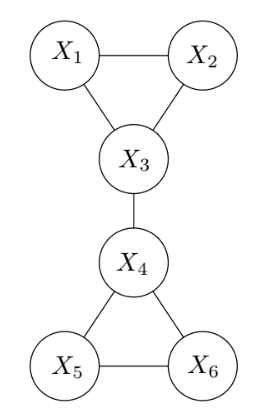

In [0]:
from IPython.display import Image
Image(filename='2018-12-01_269x415.png', width=200) 

$maximize_{S\in S_{++}^6}  log det(S) - trace(S\Sigma)$ s.t. LC below is True

In [151]:
from scipy.io import loadmat
import numpy as np
np.set_printoptions(precision=2, suppress=True)

def proj(x):
    LC = np.ones((6,6), dtype='float')
    LC[0,3] = LC[3,0] = LC[0,4] = LC[4,0] = LC[0,5] = LC[5,0] = 0
    LC[1,3] = LC[3,1] = LC[1,4] = LC[4,1] = LC[1,5] = LC[5,1] = 0
    LC[2,4] = LC[4,2] = LC[2,5] = LC[5,2] = 0
    l,v = np.linalg.eig(x)
    l[l<0] = 0
    l = np.diag(l)
    return np.real(v@l@np.linalg.inv(v))*LC
    
X = loadmat('hw10p2data.mat')['X']
Sigma = X@X.T/X.shape[1]
R = np.random.randn(6,6)
S = proj(R@R.T)
er = lambda S:  np.log(np.linalg.det(S)) - np.trace(S@Sigma)

a = 1e-1
for k in range(10000):
    error =  er(S)
    d = np.linalg.inv(S) - Sigma
    S += a*d
    S = proj(S)

R1 = np.linalg.inv(S)
print('MLE Constrained - Error:{:.3f}'.format(er(S)))
print(R1)
print('MLE Unconstrained - Error:{:.3f}'.format(er(np.linalg.inv(Sigma))))
print(Sigma)
  


9999
MLE Constrained - Error:6.091
[[ 0.16 -0.02  0.01 -0.   -0.    0.  ]
 [-0.02  0.14  0.   -0.   -0.    0.  ]
 [ 0.01  0.    0.12 -0.02 -0.    0.  ]
 [-0.   -0.   -0.02  0.14  0.01 -0.01]
 [-0.   -0.   -0.    0.01  0.13  0.02]
 [ 0.    0.    0.   -0.01  0.02  0.12]]
MLE Unconstrained - Error:6.106
[[ 0.16 -0.02  0.01  0.    0.    0.01]
 [-0.02  0.14  0.   -0.01 -0.01  0.01]
 [ 0.01  0.    0.12 -0.02 -0.    0.  ]
 [ 0.   -0.01 -0.02  0.14  0.01 -0.01]
 [ 0.   -0.01 -0.    0.01  0.13  0.02]
 [ 0.01  0.01  0.   -0.01  0.02  0.12]]


# 3. Monte Carlo $E[Z_M]$

Text(0,0.5,'E[Z_M]')

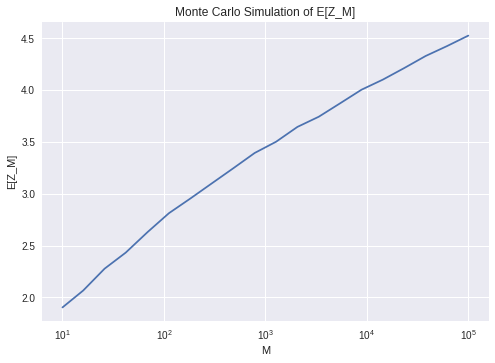

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from time import time
Mlist = np.logspace(1,5,20).astype(int)
EZlist = []
for M in Mlist:
    X = np.random.randn(1000,M)
    Z = np.abs(X).max(1)
    EZlist.append(Z.mean(0))
plt.semilogx(Mlist, EZlist)
plt.title('Monte Carlo Simulation of E[Z_M]')
plt.xlabel('M')
plt.ylabel('E[Z_M]')

# 4. Coupled Random Variables

## a.

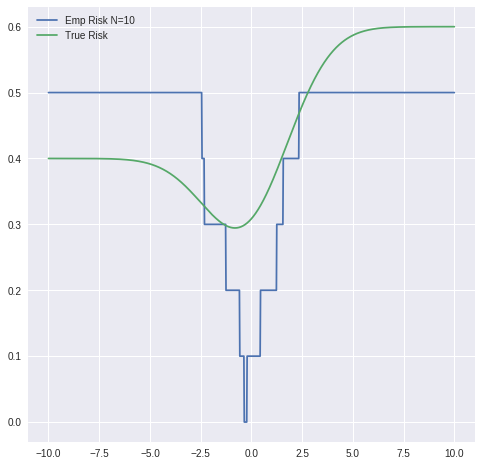

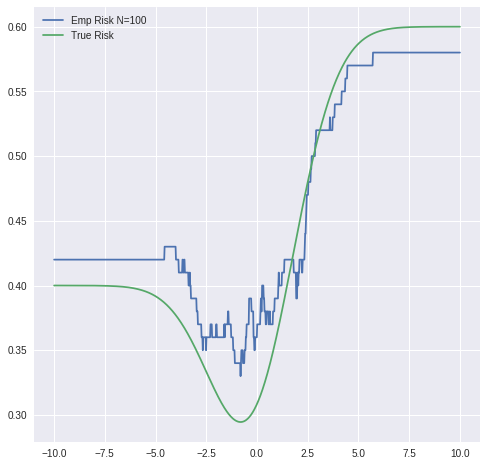

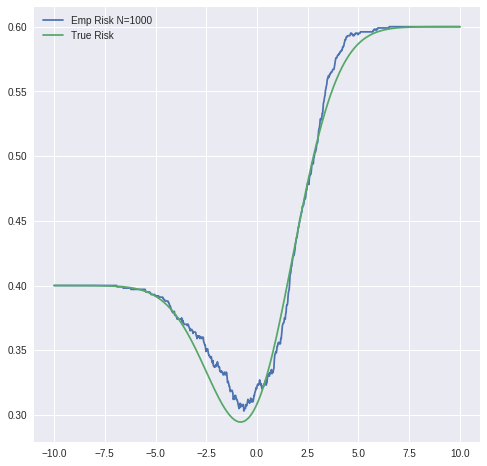

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, bernoulli
from scipy.integrate import quad

theta = np.linspace(-10,10,1000).reshape(1,1000)
for N in [10,100,1000]:
    Y = bernoulli.rvs(0.6,0.0, (N,1))
    XY0 = norm.rvs(-1, 2, (N,1))
    XY1 = norm.rvs(1, 2, (N,1))
    Z0 = (Y==0) * XY0  
    Z1 = (Y==1) * XY1
    X = Z0 + Z1

    cdf0 = lambda x: norm.cdf(x, loc=-1, scale=2)
    cdf1 = lambda x: norm.cdf(x, loc=1, scale=2)
    Rh_theta = 0.6*(cdf1(theta)-cdf1(-np.inf)) + 0.4*(cdf0(np.inf)-cdf0(theta))

    Remp = ((X <= theta) == Y).mean(0)
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.plot(theta[0], Remp, label='Emp Risk N={}'.format(N))
    ax.plot(theta[0], Rh_theta[0], label='True Risk')
    ax.legend()


## b.

In [37]:
risk_diff = 0
theta = 0.8
cdf0 = lambda x: norm.cdf(x, loc=-1, scale=2)
cdf1 = lambda x: norm.cdf(x, loc=1, scale=2)
R = 0.6*(cdf1(theta)-cdf1(-np.inf)) + 0.4*(cdf0(np.inf)-cdf0(theta))
n = 10000
for N in [10, 100, 1000]:
    Y = bernoulli.rvs(0.6,0.0, (N,n))
    XY0 = norm.rvs(-1, 2, (N,n))
    XY1 = norm.rvs(1, 2, (N,n))
    Z0 = (Y==0) * XY0  
    Z1 = (Y==1) * XY1
    X = Z0 + Z1
    Remp = ((X <= theta) == Y).mean(0)
    risk_diff = np.abs(R - Remp).mean()
    print('|R(h)-R_N(h)| = {:.3f} for N = {}'.format(risk_diff, N))
   

|R(h)-R_N(h)| = 0.124 for N = 10
|R(h)-R_N(h)| = 0.037 for N = 100
|R(h)-R_N(h)| = 0.012 for N = 1000


## c.

In [49]:
risk_diff = 0
cdf0 = lambda x: norm.cdf(x, loc=-1, scale=2)
cdf1 = lambda x: norm.cdf(x, loc=1, scale=2)
n = 100
m = 1000
theta = np.linspace(-10,10,n)
R = 0.6*(cdf1(theta)-cdf1(-np.inf)) + 0.4*(cdf0(np.inf)-cdf0(theta))
for N in [10, 100, 1000]:
    Y = bernoulli.rvs(0.6,0.0, (N,n,m))
    XY0 = norm.rvs(-1, 2, (N,n,m))
    XY1 = norm.rvs(1, 2, (N,n,m))
    Z0 = (Y==0) * XY0  
    Z1 = (Y==1) * XY1
    X = Z0 + Z1
    Remp = ((X <= theta.reshape(1,n,1)) == Y).mean(0)
    risk_diff = np.abs(R.reshape(n,1) - Remp).max(0).mean()
    print('max|R(h)-R_N(h)| = {:.3f} for N = {}'.format(risk_diff, N))
   

max|R(h)-R_N(h)| = 0.404 for N = 10
max|R(h)-R_N(h)| = 0.132 for N = 100
max|R(h)-R_N(h)| = 0.042 for N = 1000


## d.

In [90]:
risk_diff = 0
cdf0 = lambda x: norm.cdf(x, loc=-1, scale=2)
cdf1 = lambda x: norm.cdf(x, loc=1, scale=2)
n = 1000
m = 200
theta = np.linspace(-10,10,n)
R = 0.6*(cdf1(theta)-cdf1(-np.inf)) + 0.4*(cdf0(np.inf)-cdf0(theta))
for N in [10, 100, 1000]:
    Y = bernoulli.rvs(0.6,0.0, (N,n,m))
    XY0 = norm.rvs(-1, 2, (N,n,m))
    XY1 = norm.rvs(1, 2, (N,n,m))
    Z0 = (Y==0) * XY0  
    Z1 = (Y==1) * XY1
    X = Z0 + Z1
    Remp = ((X <= theta.reshape(1,n,1)) == Y).mean(0)
    theta_ = theta[Remp.argmin(0)].mean(0)
    Remp = ((X <= theta_) == Y)[0,:,0].mean()
    
    risk_diff = 0.6*(cdf1(theta)-cdf1(-np.inf)) + 0.4*(cdf0(np.inf)-cdf0(theta))
    theta_bayes = theta[risk_diff.argmin(0)]
    risk_diff = 0.6*(cdf1(theta_bayes)-cdf1(-np.inf)) + 0.4*(cdf0(np.inf)-cdf0(theta_bayes))
    print('R(hn) = {:.3f} for N = {}'.format(risk_diff, N))
    print('R_N(hn) = {:.3f} for N = {}'.format(Remp, N))

R(hn) = 0.295 for N = 10
R_N(hn) = 0.417 for N = 10
R(hn) = 0.295 for N = 100
R_N(hn) = 0.305 for N = 100
R(hn) = 0.295 for N = 1000
R_N(hn) = 0.281 for N = 1000


# 5.

1000
-179872.9283725794
-2235.5390120974835
-1945.8401233563136
(16, 80)
(16, 80)
(1, 1, 5, 2)


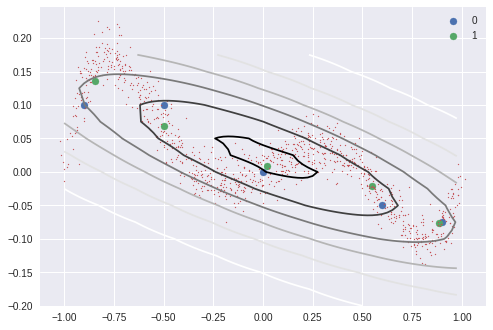

In [485]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat


X = loadmat('hw10p5data.mat')['X'].reshape(2,1,1,1000).transpose(3,2,1,0)
N = X.shape[0]
print(N)
q = 5
B = np.random.rand(1,q,1,1)
B /= B.sum()
mu = np.random.randn(1,1,q,2)/1
mu[0,0,0,:] = [-.9,0.1]
mu[0,0,1,:] = [-.5,0.1]
mu[0,0,2,:] = [-.0,0.00]
mu[0,0,3,:] = [.6,-0.05]
mu[0,0,4,:] = [.9,-0.075]
S = np.repeat(np.eye(2).reshape(1,1,1,2,2),q,2)*.01

def biginv(s):
    ss = []
    for s_ in s.transpose(2,0,1,3,4):
        ss.append(np.linalg.inv(s_.squeeze()))
    ss = np.expand_dims(np.expand_dims(np.stack(ss),0),0)
    return ss
    

def phi(S, X, mu):
    yy = 1/(2*np.pi*np.sqrt(np.linalg.det(S)))
    yy = np.expand_dims(np.expand_dims(yy, -1),-1)
    xmu = X-mu
    sinv = biginv(S).transpose(0,2,1,3,4).squeeze(2)
    d = (xmu.transpose(0,2,1,3)@sinv)
    w = d@xmu.transpose(0,2,3,1)
    rr = np.exp(-0.5*(w))
    return (yy*rr).squeeze(0)
    
def logloss(B, phi):
    return np.log(B).sum() + np.log(phi).sum()

def gamma(B, phi):
    b = B*phi
    bs = b.sum(1,keepdims=True)
    return b/bs

def proj(x):
    ss = []
    for x_ in x.transpose(2,0,1,3,4):
        l,v = np.linalg.eig(x_.squeeze())
        l[l<0] = 0
        l = np.diag(l)
        ss.append( np.real(v@l@np.linalg.inv(v)))
    ss = np.expand_dims(np.expand_dims(np.stack(ss),0),0)
    return ss

p = phi(proj(S),X,mu)
l = logloss(B,p)
print(l)

for n in range(2):
    plt.scatter(mu.squeeze()[:,0], mu.squeeze()[:,1], label=n)
    g_ = gamma(B, p)
    gsum = g_.sum(0, keepdims=True)
    B_ = gsum/N
    B_/=B_.sum()
    mu_ = (g_*X).sum(0, keepdims=True)/(gsum)
    mu = mu_.transpose(0,2,1,3)
    
    xmu_ = X-mu_
    S_ = np.expand_dims((xmu_.transpose(1,2,3,0)@xmu_.transpose(1,2,0,3)).transpose(1,0,2,3),0)
    S_ /= g_.sum(0)
    S_ = proj(S_)
    S = S_
    
    B = B_
    p = phi(S,X,mu)
    
    l_ = logloss(B,p)
    print(l_)
    #print(l_ - l)
    l = l_
    
delta = 0.025
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-.2, .2, delta)
xm,ym = np.meshgrid(x, y)
print(xm.shape)
XY = np.stack((xm.reshape(-1), ym.reshape(-1))).reshape(2,1280,1,1).transpose(1,2,3,0)
Z = phi(S,XY,mu).reshape(16,80,5).transpose(2,0,1).mean(0)
print(Z.shape)
print(mu.shape)

plt.contour(xm, ym, Z)
plt.scatter(X[:,0,0,0], X[:,0,0,1], s=1.0)
plt.legend()